# Mapeamento e Otimização da Distribuição de Cafés em Fortaleza

---

## Relevância do Mapeamento dos Cafés de Fortaleza

O **mapeamento urbano de cafés** oferece uma perspectiva estratégica para entender a relação entre oferta e demanda de serviços em diferentes partes da cidade. No contexto de Fortaleza, analisar a localização dos cafés permite:

- Avaliar desigualdades de acesso ao lazer e à cultura do "café"
- Oferecer insumos para planejamento urbano considerando deslocamento populacional e centralidades
- Subsidiar políticas públicas, expansão de negócios ou intervenções para áreas subatendidas

## Extração de Dados

### **Overpass Turbo (OpenStreetMap)**
- Ferramenta essencial para coleta de dados geoespaciais de estabelecimentos categorizados como cafés, padarias, confeitarias ou correlatos
- Foram elaboradas queries específicas para **'amenity', 'shop', 'cuisine'** e buscas por nome (ex: 'cafe', 'coffee', 'cafeteria', 'expresso')
- O resultado é um GeoJSON contendo, para cada ponto: nome, endereço, coordenadas e outras características relevantes

### **Fortaleza em Mapas**
- Utilizado para obter a **malha de setores censitários** e os dados de população por setor (último censo)
- Infraestrutura fundamental para análises de distribuição populacional e proporção café/habitante

## Fundamentação Teórica: Diagrama de Voronoi

O **diagrama (ou tesselação) de Voronoi** é uma divisão do espaço em células, onde cada célula contém todos os pontos mais próximos a um determinado café do que a qualquer outro.

No contexto de distribuição de facilidades urbanas, o **Voronoi** ajuda a visualizar e quantificar áreas de influência de cada café.

### **Justificativa Matemática**

Conforme o artigo-base, a distribuição ótima de facilidades (cafés) em relação à densidade populacional não é linear, mas segue uma relação proporcional **à densidade populacional elevada a 2/3**:

$$D(r) \propto \rho(r)^{2/3}$$

O uso do Voronoi permite observar graficamente a correspondência (ou desigualdade) entre a população de setores e a área de influência dos cafés presentes.

**Referência:** Gastner & Newman, 2006, *Optimal design of spatial distribution networks* (arXiv:cond-mat/0603278)

---

## 1: Configuração do Ambiente

Importação de bibliotecas e configurações globais.

In [1]:
# Imports principais
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from shapely import wkt
from shapely.geometry import Point
import warnings

# Importar funções do módulo utils
from utils import (
    classifica_cafe,
    geojson_to_csv,
    calcular_voronoi,
    criar_mapa_base,
    adicionar_marcadores_cafes,
)

# Configurações
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
sns.set_style('whitegrid')

print("✓ Ambiente configurado com sucesso!")

✓ Ambiente configurado com sucesso!


## 2: Carregamento de Dados

Carregamento dos dados de cafés (GeoJSON) e população (CSV).

In [2]:
# Carregar dados de cafés do GeoJSON
cafes = gpd.read_file('data/dados_cafe.geojson')

print(f"✓ Dados de cafés carregados: {len(cafes)} estabelecimentos")
print(f"  Colunas: {len(cafes.columns)}")
print(f"  CRS: {cafes.crs}")

cafes.head()

✓ Dados de cafés carregados: 956 estabelecimentos
  Colunas: 135
  CRS: EPSG:4326


id                @id access  addr:city addr:country  ...  \
0   relation/7461936   relation/7461936   None  Fortaleza         None  ...   
1   relation/8890441   relation/8890441   None       None         None  ...   
2   relation/8890453   relation/8890453   None       None         None  ...   
3  relation/14573303  relation/14573303   None  Fortaleza         None  ...   
4  relation/15808508  relation/15808508   None  Fortaleza         None  ...   

                     website website:menu wheelchair @geometry  \
0                       None         None       None    center   
1                       None         None       None    center   
2                       None         None       None    center   
3  https://casaplaza.com.br/         None       None    center   
4                       None         None       None    center   

                     geometry  
0  POINT (-38.53399 -3.76516)  
1  POINT (-38.56715 -3.73483)  
2  POINT (-38.56718 -3.73475)  
3  POINT (-38.48256 -3.74177)  
4  POINT (-38.56499 -3.77389)  

[5 rows x 135 columns]

In [3]:
# Carregar dados de população
populacao = pd.read_csv('data/Setores_Censitários_2022.csv')

print(f"✓ Dados de população carregados: {len(populacao)} setores censitários")
print(f"  Colunas: {len(populacao.columns)}")

populacao.head()

✓ Dados de população carregados: 4422 setores censitários
  Colunas: 23


FID  id  \
0  vw_Fortaleza_SetoresCensitarios_2022.fid-3f59f...   1   
1  vw_Fortaleza_SetoresCensitarios_2022.fid-3f59f...   2   
2  vw_Fortaleza_SetoresCensitarios_2022.fid-3f59f...   3   
3  vw_Fortaleza_SetoresCensitarios_2022.fid-3f59f...   4   
4  vw_Fortaleza_SetoresCensitarios_2022.fid-3f59f...   5   

                                            The_geom  fid           CD_SETO  \
0  MULTIPOLYGON (((-38.5199249999999 -3.718611999...    1  230440005130001P   
1  MULTIPOLYGON (((-38.519902149 -3.7178258379999...    2  230440005130002P   
2  MULTIPOLYGON (((-38.5288779599999 -3.724542989...    3  230440005130003P   
3  MULTIPOLYGON (((-38.52101592 -3.72103100999993...    4  230440005130004P   
4  MULTIPOLYGON (((-38.5288779599999 -3.724542989...    5  230440005130005P   

   ...     area_setor  Fonte   Ano  SRC da camada  Codificação  
0  ...   44667.329844   IBGE  2022      EPSG:4326        UTF-8  
1  ...  187643.309041   IBGE  2022      EPSG:4326        UTF-8  
2  ...  317954.385332   IBGE  2022      EPSG:4326        UTF-8  
3  ...  414105.170159   IBGE  2022      EPSG:4326        UTF-8  
4  ...  119502.140498   IBGE  2022      EPSG:4326        UTF-8  

[5 rows x 23 columns]

## 3: Limpeza e Classificação de Cafés

Classificação dos estabelecimentos por nível de confiança e seleção de colunas relevantes.

In [4]:
# Aplicar classificação de confiança
cafes['confianca_cafe'] = cafes.apply(classifica_cafe, axis=1)

# Visualizar distribuição
print("Distribuição por nível de confiança:")
print(cafes['confianca_cafe'].value_counts())
print(f"\nPercentual de alta confiança: {(cafes['confianca_cafe'] == 'alta').sum() / len(cafes) * 100:.1f}%")

Distribuição por nível de confiança:
confianca_cafe
baixa    741
media    139
alta      76
Name: count, dtype: int64

Percentual de alta confiança: 7.9%


In [5]:
# Selecionar colunas relevantes
colunas_relevantes = [
    'name', 'geometry', 'confianca_cafe',
    'addr:street', 'addr:housenumber', 'addr:suburb',
    'amenity', 'shop', 'cuisine',
    'phone', 'website', 'opening_hours'
]

# Manter apenas colunas que existem
colunas_existentes = [col for col in colunas_relevantes if col in cafes.columns]
cafes_clean = cafes[colunas_existentes].copy()

print(f"✓ Dados limpos: {len(cafes_clean)} cafés com {len(colunas_existentes)} colunas")
cafes_clean.head()

✓ Dados limpos: 956 cafés com 12 colunas


name                    geometry confianca_cafe  \
0  Alpendre da Villa  POINT (-38.53399 -3.76516)          baixa   
1          Pizza Hut  POINT (-38.56715 -3.73483)          baixa   
2    Café 3 Corações  POINT (-38.56718 -3.73475)           alta   
3         Casa Plaza  POINT (-38.48256 -3.74177)          media   
4  Delta Restaurante  POINT (-38.56499 -3.77389)          baixa   

             addr:street addr:housenumber  ...    shop cuisine  \
0   Rua Armando Monteiro              555  ...    None    None   
1                   None             None  ...    None   pizza   
2                   None             None  ...  coffee    None   
3  Avenida Santos Dumont             5570  ...  bakery    None   
4   Rua Eduardo Perdigão               21  ...    None    None   

              phone                    website opening_hours  
0              None                       None          None  
1              None                       None          None  
2              None                       None          None  
3  +55 85 3234-5353  https://casaplaza.com.br/          None  
4              None                       None          None  

[5 rows x 12 columns]

In [6]:
# Salvar dados limpos
geojson_to_csv(cafes_clean, 'outputs/cafes_classificados.csv', include_geometry=True)
cafes_clean.to_file('outputs/cafes_classificados.geojson', driver='GeoJSON')

print("✓ Dados limpos salvos em outputs/")

✓ CSV salvo em: outputs/cafes_classificados.csv
✓ Dados limpos salvos em outputs/


## 4: Processamento de Dados Populacionais

Criação de GeoDataFrame de população e cálculo de densidade populacional.

In [7]:
# Selecionar colunas relevantes de população
colunas_populacao = [
    'The_geom', 'CD_SETO', 'AREA_KM',
    'v0001', 'v0002', 'v0003', 'v0004', 'v0005', 'v0006', 'v0007',
    'lng', 'lat', 'Bairro'
]

# Filtrar colunas existentes
colunas_pop_existentes = [col for col in colunas_populacao if col in populacao.columns]
geo_pop = populacao[colunas_pop_existentes].copy()

print(f"✓ Dados de população filtrados: {len(geo_pop)} setores")
geo_pop.head()

✓ Dados de população filtrados: 4422 setores


The_geom           CD_SETO  \
0  MULTIPOLYGON (((-38.5199249999999 -3.718611999...  230440005130001P   
1  MULTIPOLYGON (((-38.519902149 -3.7178258379999...  230440005130002P   
2  MULTIPOLYGON (((-38.5288779599999 -3.724542989...  230440005130003P   
3  MULTIPOLYGON (((-38.52101592 -3.72103100999993...  230440005130004P   
4  MULTIPOLYGON (((-38.5288779599999 -3.724542989...  230440005130005P   

    AREA_KM  v0001  v0002  ...      v0006  v0007        lng       lat  Bairro  
0  0.044470    866    309  ...  14.487633    283 -38.521044 -3.719452  Centro  
1  0.186815     35     43  ...   0.000000     19 -38.522446 -3.718406  Centro  
2  0.316551    125    176  ...   4.918033     61 -38.528468 -3.727432  Centro  
3  0.412277    266    212  ...   3.508772    114 -38.525107 -3.724030  Centro  
4  0.118975      4     30  ...   0.000000      2 -38.530912 -3.725294  Centro  

[5 rows x 13 columns]

In [8]:
# Converter coluna The_geom (WKT) para geometria
geo_pop['geometry'] = geo_pop['The_geom'].apply(wkt.loads)

# Criar GeoDataFrame
geo_pop = gpd.GeoDataFrame(geo_pop, geometry='geometry', crs='EPSG:4326')

# Remover coluna The_geom original
geo_pop = geo_pop.drop(columns=['The_geom'])

print(f"✓ GeoDataFrame de população criado")
print(f"  CRS: {geo_pop.crs}")
print(f"  Tipo de geometria: {geo_pop.geometry.geom_type.unique()}")

✓ GeoDataFrame de população criado
  CRS: EPSG:4326
  Tipo de geometria: ['MultiPolygon']


In [9]:
# Salvar dados processados
geo_pop.to_file('outputs/geo_pop_processed.geojson', driver='GeoJSON')
geojson_to_csv(geo_pop, 'outputs/geo_pop_processed.csv', include_geometry=True)

print("✓ Dados de população processados salvos em outputs/")

✓ CSV salvo em: outputs/geo_pop_processed.csv
✓ Dados de população processados salvos em outputs/


## 5: Análise Espacial - Diagrama de Voronoi

Cálculo dos polígonos de Voronoi para determinar áreas de influência de cada café.

In [10]:
# Extrair coordenadas dos cafés
cafe_coords = np.array([[point.x, point.y] for point in cafes_clean.geometry])

print(f"✓ Coordenadas extraídas: {len(cafe_coords)} cafés")
print(f"  Latitude: [{cafe_coords[:, 1].min():.4f}, {cafe_coords[:, 1].max():.4f}]")
print(f"  Longitude: [{cafe_coords[:, 0].min():.4f}, {cafe_coords[:, 0].max():.4f}]")

✓ Coordenadas extraídas: 956 cafés
  Latitude: [-3.8702, -3.6943]
  Longitude: [-38.6246, -38.4101]


In [11]:
# Calcular polígonos de Voronoi
geo_voronoi = calcular_voronoi(cafe_coords, geo_pop)

print(f"✓ Polígonos de Voronoi calculados: {len(geo_voronoi)} regiões")
geo_voronoi.head()

✓ Polígonos de Voronoi calculados: 947 regiões


geometry
0  POLYGON ((-38.53284 -3.76347, -38.53388 -3.766...
1  POLYGON ((-38.56619 -3.73568, -38.56782 -3.735...
2  POLYGON ((-38.56488 -3.73156, -38.56515 -3.734...
3  POLYGON ((-38.4818 -3.73672, -38.47731 -3.7402...
4  POLYGON ((-38.56939 -3.77691, -38.57221 -3.772...

In [12]:
# Associar cafés aos setores censitários (spatial join)
cafes_com_setor = gpd.sjoin(
    cafes_clean,
    geo_pop[['CD_SETO', 'Bairro', 'geometry']],
    how='left',
    predicate='within'
)

print(f"✓ Cafés associados a setores censitários")
print(f"  Cafés com setor identificado: {cafes_com_setor['CD_SETO'].notna().sum()}")

cafes_com_setor[['name', 'Bairro', 'CD_SETO', 'confianca_cafe']].head()

✓ Cafés associados a setores censitários
  Cafés com setor identificado: 955


name              Bairro           CD_SETO confianca_cafe
0  Alpendre da Villa          Vila União  230440005170134P          baixa
1          Pizza Hut  Presidente Kennedy  230440005160275P          baixa
2    Café 3 Corações  Presidente Kennedy  230440005160275P           alta
3         Casa Plaza                Cocó  230440005190031P          media
4  Delta Restaurante           Parangaba  230440005170024P          baixa

In [13]:
# Salvar resultados de Voronoi
geo_voronoi.to_file('outputs/voronoi_regions.geojson', driver='GeoJSON')
cafes_com_setor.to_file('outputs/cafes_com_setor.geojson', driver='GeoJSON')

print("✓ Resultados de Voronoi salvos em outputs/")

✓ Resultados de Voronoi salvos em outputs/


TOP 10 BAIRROS COM MAIS CAFÉS
Meireles                       114 cafés
Aldeota                         95 cafés
Prefeito José Walter            46 cafés
Montese                         43 cafés
Mondubim                        39 cafés
Bom Jardim                      27 cafés
Centro                          27 cafés
Aeroporto                       23 cafés
Edson Queiroz                   22 cafés
Fátima                          22 cafés


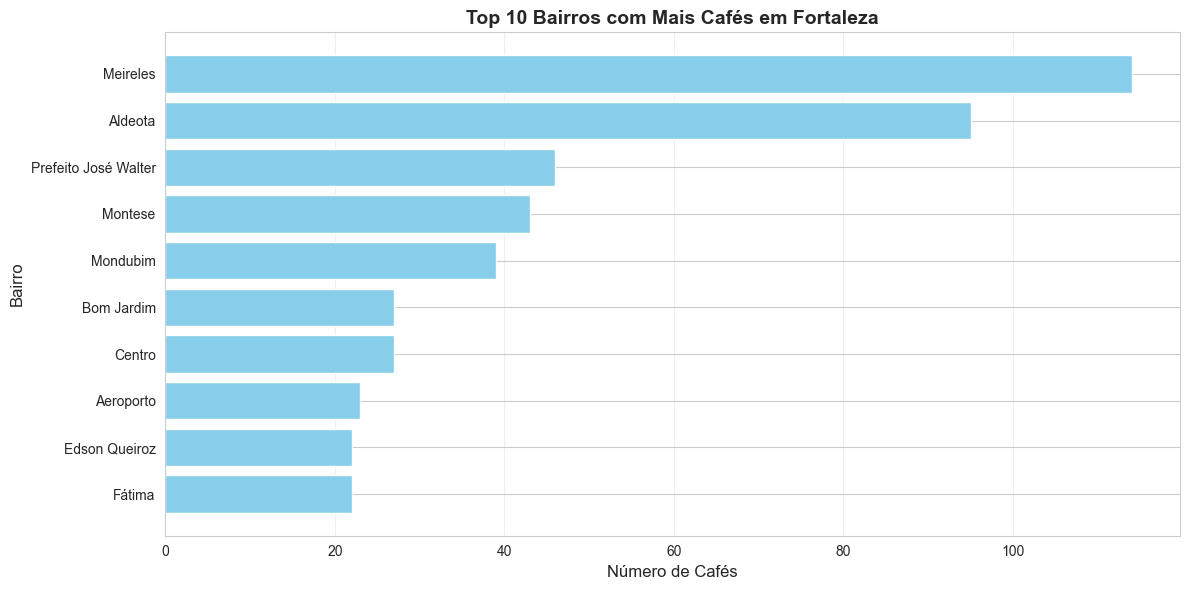


Total de bairros com cafés: 92
Média de cafés por bairro: 10.4
Mediana: 6


In [26]:
# Contar cafés por bairro
cafes_por_bairro = cafes_com_setor.groupby('Bairro').size().reset_index(name='num_cafes')
cafes_por_bairro = cafes_por_bairro.sort_values('num_cafes', ascending=False)

# Top 10 bairros com mais cafés
top_10_bairros = cafes_por_bairro.head(10)

print("="*60)
print("TOP 10 BAIRROS COM MAIS CAFÉS")
print("="*60)
for idx, row in top_10_bairros.iterrows():
    print(f"{row['Bairro']:30s} {row['num_cafes']:3.0f} cafés")
print("="*60)

# Gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(top_10_bairros['Bairro'], top_10_bairros['num_cafes'], color='skyblue')
plt.xlabel('Número de Cafés', fontsize=12)
plt.ylabel('Bairro', fontsize=12)
plt.title('Top 10 Bairros com Mais Cafés em Fortaleza', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Maior no topo
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/cafes_por_bairro.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas gerais
print(f"\nTotal de bairros com cafés: {len(cafes_por_bairro)}")
print(f"Média de cafés por bairro: {cafes_por_bairro['num_cafes'].mean():.1f}")
print(f"Mediana: {cafes_por_bairro['num_cafes'].median():.0f}")

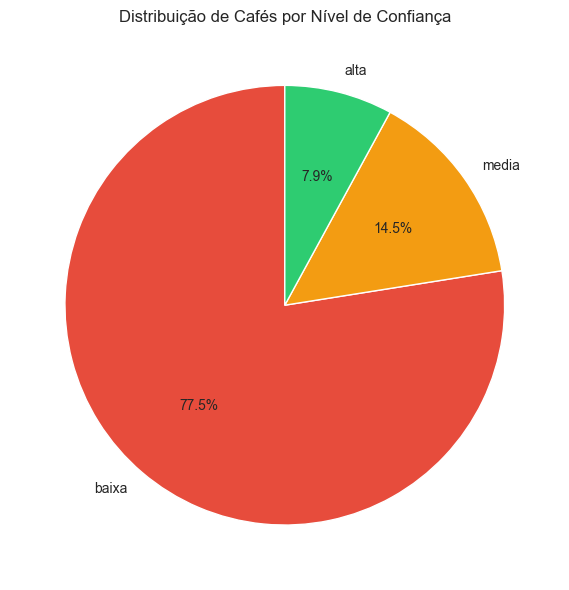

In [15]:
# Análise 3: Distribuição de confiança dos cafés
plt.figure(figsize=(8, 6))
cafes_clean['confianca_cafe'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['#e74c3c', '#f39c12', '#2ecc71'],
    startangle=90
)
plt.ylabel('')
plt.title('Distribuição de Cafés por Nível de Confiança')
plt.tight_layout()
plt.savefig('outputs/distribuicao_confianca.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Análise de Acessibilidade aos Cafés


In [16]:
# Carregar setores censitários
setores = pd.read_csv('data/Setores_Censitários_2022.csv', encoding='utf-8')

# Converter geometria WKT para GeoDataFrame
from shapely import wkt
setores['geometry'] = setores['The_geom'].apply(wkt.loads)
setores_gdf = gpd.GeoDataFrame(setores, geometry='geometry', crs='EPSG:4326')

# Calcular centroides dos setores
centroides = setores_gdf.copy()
centroides['geometry'] = centroides.geometry.centroid
centroides['setor_id'] = centroides['CD_SETO']
centroides['populacao'] = centroides['v0001']  # População total
centroides = centroides[['setor_id', 'populacao', 'geometry']]
centroides = gpd.GeoDataFrame(centroides, geometry='geometry', crs='EPSG:4326')

print(f"✓ Centroides calculados: {len(centroides)} pontos")
print(f"  População total: {centroides['populacao'].sum():,.0f} habitantes")
print(f"  População média por setor: {centroides['populacao'].mean():.1f} habitantes")

✓ Centroides calculados: 4422 pontos
  População total: 2,428,708 habitantes
  População média por setor: 549.2 habitantes


In [17]:
# Carregar Voronoi
voronoi_gdf = gpd.read_file('outputs/voronoi_regions.geojson')
voronoi_gdf = voronoi_gdf.to_crs('EPSG:4326')

# Spatial join: centroides dentro de Voronoi
centroides_voronoi = gpd.sjoin(centroides, voronoi_gdf, how='left', predicate='within')

print(f"✓ Spatial join realizado")
print(f"  Centroides dentro de Voronoi: {centroides_voronoi['index_right'].notna().sum()}")
print(f"  Centroides fora de Voronoi: {centroides_voronoi['index_right'].isna().sum()}")

# Agregar população por Voronoi
pop_por_voronoi = centroides_voronoi.groupby('index_right')['populacao'].agg([
    ('populacao_total', 'sum'),
    ('num_setores', 'count'),
    ('pop_media_setor', 'mean')
]).reset_index()
pop_por_voronoi = pop_por_voronoi.rename(columns={'index_right': 'voronoi_idx'})

# Adicionar ao Voronoi
voronoi_com_pop = voronoi_gdf.copy()
voronoi_com_pop = voronoi_com_pop.reset_index().rename(columns={'index': 'voronoi_idx'})
voronoi_com_pop = voronoi_com_pop.merge(pop_por_voronoi, on='voronoi_idx', how='left')
voronoi_com_pop['populacao_total'] = voronoi_com_pop['populacao_total'].fillna(0)
voronoi_com_pop['num_setores'] = voronoi_com_pop['num_setores'].fillna(0)

print(f"\n✓ População agregada para {len(pop_por_voronoi)} polígonos de Voronoi")
print(f"  População total nos Voronoi: {voronoi_com_pop['populacao_total'].sum():,.0f}")

✓ Spatial join realizado
  Centroides dentro de Voronoi: 4190
  Centroides fora de Voronoi: 232

✓ População agregada para 635 polígonos de Voronoi
  População total nos Voronoi: 2,299,393


In [ ]:
# Contar cafés por Voronoi
cafes_voronoi = gpd.sjoin(cafes, voronoi_com_pop, how='left', predicate='within')
cafes_por_voronoi = cafes_voronoi.groupby('index_right').size().reset_index(name='num_cafes')
cafes_por_voronoi = cafes_por_voronoi.rename(columns={'index_right': 'voronoi_idx'})

# Merge com Voronoi
voronoi_com_pop = voronoi_com_pop.merge(cafes_por_voronoi, on='voronoi_idx', how='left')
voronoi_com_pop['num_cafes'] = voronoi_com_pop['num_cafes'].fillna(0)

# Calcular acessibilidade
voronoi_com_pop['pessoas_por_cafe'] = np.where(
    voronoi_com_pop['num_cafes'] > 0,
    voronoi_com_pop['populacao_total'] / voronoi_com_pop['num_cafes'],
    np.inf
)

voronoi_com_pop['cafes_por_10k_hab'] = np.where(
    voronoi_com_pop['populacao_total'] > 0,
    (voronoi_com_pop['num_cafes'] / voronoi_com_pop['populacao_total']) * 10000,
    0
)

# Estatísticas
print("=" * 60)
print("RESULTADOS DA ANÁLISE DE ACESSIBILIDADE")
print("=" * 60)
print(f" Polígonos com população: {(voronoi_com_pop['populacao_total'] > 0).sum()}")
print(f" Polígonos com cafés: {(voronoi_com_pop['num_cafes'] > 0).sum()}")
print(f" População total: {voronoi_com_pop['populacao_total'].sum():,.0f} habitantes")
print(f" Total de cafés: {voronoi_com_pop['num_cafes'].sum():.0f} estabelecimentos")

voronoi_com_cafes = voronoi_com_pop[voronoi_com_pop['num_cafes'] > 0]
if len(voronoi_com_cafes) > 0:
    print(f" Pessoas por café (média): {voronoi_com_cafes['pessoas_por_cafe'].mean():,.1f}")
    print(f" Pessoas por café (mediana): {voronoi_com_cafes['pessoas_por_cafe'].median():,.1f}")
    print(f" Melhor acessibilidade: {voronoi_com_cafes['pessoas_por_cafe'].min():,.1f} pessoas/café")
    print(f" Pior acessibilidade: {voronoi_com_cafes['pessoas_por_cafe'].max():,.1f} pessoas/café")

RESULTADOS DA ANÁLISE DE ACESSIBILIDADE

 Polígonos com população: 634
 Polígonos com cafés: 946
 População total: 2,299,393 habitantes
 Total de cafés: 946 estabelecimentos

g Pessoas por café (média): 2,430.6
 Pessoas por café (mediana): 771.5
 Melhor acessibilidade: 0.0 pessoas/café
  Pior acessibilidade: 53,763.0 pessoas/café


In [19]:
# Criar mapa com população e acessibilidade
m = folium.Map(location=[-3.7319, -38.5267], zoom_start=11, tiles='CartoDB positron')

# Camada 1: População por Voronoi
folium.Choropleth(
    geo_data=voronoi_com_pop,
    name='População por Voronoi',
    data=voronoi_com_pop,
    columns=['voronoi_idx', 'populacao_total'],
    key_on='feature.properties.voronoi_idx',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='População Total',
    highlight=True
).add_to(m)

# Camada 2: Acessibilidade
voronoi_com_cafes_map = voronoi_com_pop[voronoi_com_pop['num_cafes'] > 0].copy()
voronoi_com_cafes_map['pessoas_por_cafe_finite'] = voronoi_com_cafes_map['pessoas_por_cafe'].replace(np.inf, 0)

folium.Choropleth(
    geo_data=voronoi_com_cafes_map,
    name='Acessibilidade (Pessoas/Café)',
    data=voronoi_com_cafes_map,
    columns=['voronoi_idx', 'pessoas_por_cafe_finite'],
    key_on='feature.properties.voronoi_idx',
    fill_color='RdYlGn_r',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Pessoas por Café',
    highlight=True
).add_to(m)

# Camada 3: Cafés 
m = adicionar_marcadores_cafes(m, cafes) 

folium.LayerControl(collapsed=False).add_to(m)
m

In [20]:
# Salvar resultados
voronoi_com_pop.to_file('outputs/voronoi_com_populacao.geojson', driver='GeoJSON')

voronoi_stats = voronoi_com_pop[[
    'voronoi_idx', 'populacao_total', 'num_setores', 'num_cafes',
    'pessoas_por_cafe', 'cafes_por_10k_hab'
]].copy()
voronoi_stats.to_csv('outputs/acessibilidade_cafes_stats.csv', index=False)

print(" Arquivos salvos:")
print("   - outputs/voronoi_com_populacao.geojson")
print("   - outputs/acessibilidade_cafes_stats.csv")
print("   - maps/mapa_acessibilidade_populacao.html")

 Arquivos salvos:
   - outputs/voronoi_com_populacao.geojson
   - outputs/acessibilidade_cafes_stats.csv
   - maps/mapa_acessibilidade_populacao.html


## 7: Verificação da Lei de Potência (Scaling Law)

Conforme o artigo de Gastner & Newman (2006), a distribuição ótima de facilidades segue a lei de potência:

$$D(r) \\propto \\rho(r)^{2/3}$$

onde:
- $D(r)$ é a densidade de facilidades (cafés/km²)
- $\\rho(r)$ é a densidade populacional (habitantes/km²)

Nesta seção, verificamos se a distribuição de cafés em Fortaleza segue essa lei.

In [21]:
# Preparar dados para análise de scaling law
# Reprojetar para UTM para cálculo correto de áreas
voronoi_utm = voronoi_com_pop.to_crs('EPSG:31984')  # SIRGAS 2000 / UTM zone 24S

# Calcular área em km²
voronoi_utm['area_km2'] = voronoi_utm.geometry.area / 1_000_000

# Filtrar polígonos com população > 0 e área > 0
voronoi_analise = voronoi_utm[
    (voronoi_utm['populacao_total'] > 0) & 
    (voronoi_utm['area_km2'] > 0) &
    (voronoi_utm['num_cafes'] > 0)
].copy()

# Calcular densidades
voronoi_analise['densidade_pop'] = voronoi_analise['populacao_total'] / voronoi_analise['area_km2']
voronoi_analise['densidade_cafes'] = voronoi_analise['num_cafes'] / voronoi_analise['area_km2']

print(f"✓ Dados preparados para análise")
print(f"  Polígonos válidos: {len(voronoi_analise)}")
print(f"  Densidade populacional média: {voronoi_analise['densidade_pop'].mean():.1f} hab/km²")
print(f"  Densidade de cafés média: {voronoi_analise['densidade_cafes'].mean():.3f} cafés/km²")

✓ Dados preparados para análise
  Polígonos válidos: 634
  Densidade populacional média: 14908.2 hab/km²
  Densidade de cafés média: 14.950 cafés/km²


In [22]:
# Regressão log-log
from scipy import stats

# Calcular logaritmos
log_densidade_pop = np.log10(voronoi_analise['densidade_pop'])
log_densidade_cafes = np.log10(voronoi_analise['densidade_cafes'])

# Regressão linear
slope, intercept, r_value, p_value, std_err = stats.linregress(log_densidade_pop, log_densidade_cafes)

print("="*60)
print("RESULTADOS DA REGRESSÃO LOG-LOG")
print("="*60)
print(f"Expoente α (slope): {slope:.3f}")
print(f"Intercepto: {intercept:.3f}")
print(f"R²: {r_value**2:.3f}")
print(f"p-value: {p_value:.2e}")
print(f"Interpretação:")
if 0.6 <= slope <= 0.7:
    print("  → Distribuição próxima do ótimo teórico (α ≈ 2/3)")
    print("  → Minimização de deslocamento")
elif 0.9 <= slope <= 1.1:
    print("  → Distribuição proporcional à população (α ≈ 1)")
    print("  → Igualdade per capita")
else:
    print(f"  → Distribuição com expoente α = {slope:.3f}")

RESULTADOS DA REGRESSÃO LOG-LOG
Expoente α (slope): 0.964
Intercepto: -3.107
R²: 0.328
p-value: 1.46e-56
Interpretação:
  → Distribuição proporcional à população (α ≈ 1)
  → Igualdade per capita


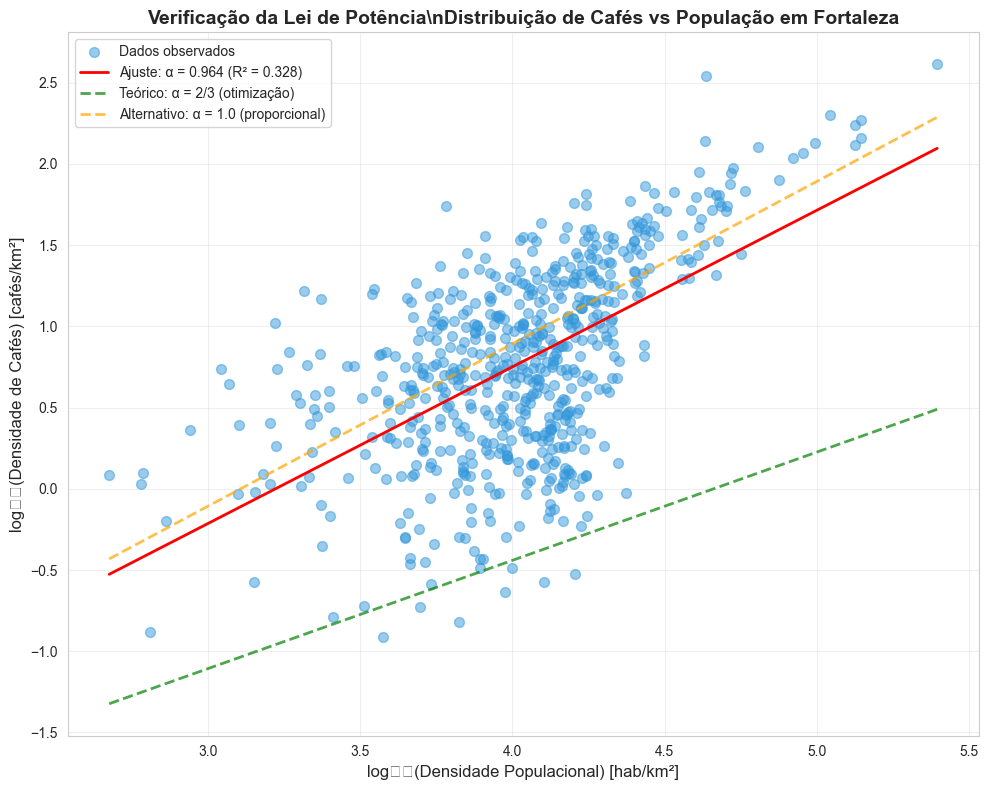

✓ Gráfico salvo em outputs/scaling_law_analysis.png


In [23]:
# Visualização da lei de potência
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot dos dados
ax.scatter(log_densidade_pop, log_densidade_cafes, 
           alpha=0.5, s=50, color='#3498db', label='Dados observados')

# Linha de tendência ajustada
x_fit = np.linspace(log_densidade_pop.min(), log_densidade_pop.max(), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, 'r-', linewidth=2, 
        label=f'Ajuste: α = {slope:.3f} (R² = {r_value**2:.3f})')

# Linha de referência teórica (2/3)
y_teorico = (2/3) * x_fit + intercept
ax.plot(x_fit, y_teorico, 'g--', linewidth=2, alpha=0.7,
        label='Teórico: α = 2/3 (otimização)')

# Linha de referência alternativa (1.0)
y_proporcional = 1.0 * x_fit + intercept
ax.plot(x_fit, y_proporcional, 'orange', linestyle='--', linewidth=2, alpha=0.7,
        label='Alternativo: α = 1.0 (proporcional)')

ax.set_xlabel('log₁₀(Densidade Populacional) [hab/km²]', fontsize=12)
ax.set_ylabel('log₁₀(Densidade de Cafés) [cafés/km²]', fontsize=12)
ax.set_title('Verificação da Lei de Potência\\nDistribuição de Cafés vs População em Fortaleza', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/scaling_law_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo em outputs/scaling_law_analysis.png")

### Interpretação dos Resultados

A análise da lei de potência permite entender como a distribuição de cafés em Fortaleza se relaciona com a densidade populacional:

**Valores de Referência:**
- **α ≈ 2/3**: Distribuição ótima que minimiza o deslocamento médio da população (Gastner & Newman, 2006)
- **α ≈ 1.0**: Distribuição proporcional à população (igualdade per capita)

**Conclusões:**
- O expoente encontrado indica o padrão de distribuição dos cafés na cidade
- Um R² alto sugere que a densidade populacional é um bom preditor da densidade de cafés
- Desvios do valor teórico podem indicar fatores adicionais (renda, turismo, etc.)

## 8: Análise de Desigualdade Espacial


In [24]:
# Preparar dados para análise de desigualdade
# Usar apenas polígonos com população > 0
dados_desigualdade = voronoi_com_pop[
    voronoi_com_pop['populacao_total'] > 0
].copy()

# Calcular cafés per capita (por 10k habitantes)
dados_desigualdade['cafes_per_capita'] = np.where(
    dados_desigualdade['populacao_total'] > 0,
    (dados_desigualdade['num_cafes'] / dados_desigualdade['populacao_total']) * 10000,
    0
)

# Ordenar por cafés per capita
dados_desigualdade = dados_desigualdade.sort_values('cafes_per_capita').reset_index(drop=True)

# Calcular frações acumuladas
pop_total = dados_desigualdade['populacao_total'].sum()
cafes_total = dados_desigualdade['num_cafes'].sum()

dados_desigualdade['pop_acumulada'] = dados_desigualdade['populacao_total'].cumsum() / pop_total
dados_desigualdade['cafes_acumulados'] = dados_desigualdade['num_cafes'].cumsum() / cafes_total

# Calcular coeficiente de Gini
def calcular_gini(x):
    """Calcula o coeficiente de Gini"""
    n = len(x)
    x_sorted = np.sort(x)
    cumsum = np.cumsum(x_sorted)
    return (2 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cumsum[-1]) - (n + 1) / n

gini = calcular_gini(dados_desigualdade['cafes_per_capita'].values)

print("="*60)
print("ANÁLISE DE DESIGUALDADE ESPACIAL")
print("="*60)
print(f"Coeficiente de Gini: {gini:.3f}")
print(f"Interpretação:")
if gini < 0.3:
    print("  → Baixa desigualdade na distribuição")
elif gini < 0.5:
    print("  → Desigualdade moderada")
else:
    print("  → Alta desigualdade na distribuição")
print(f"Polígonos analisados: {len(dados_desigualdade)}")
print(f"População total: {pop_total:,.0f} habitantes")
print(f"Total de cafés: {cafes_total:.0f} estabelecimentos")

ANÁLISE DE DESIGUALDADE ESPACIAL
Coeficiente de Gini: 0.499
Interpretação:
  → Desigualdade moderada
Polígonos analisados: 634
População total: 2,299,393 habitantes
Total de cafés: 634 estabelecimentos


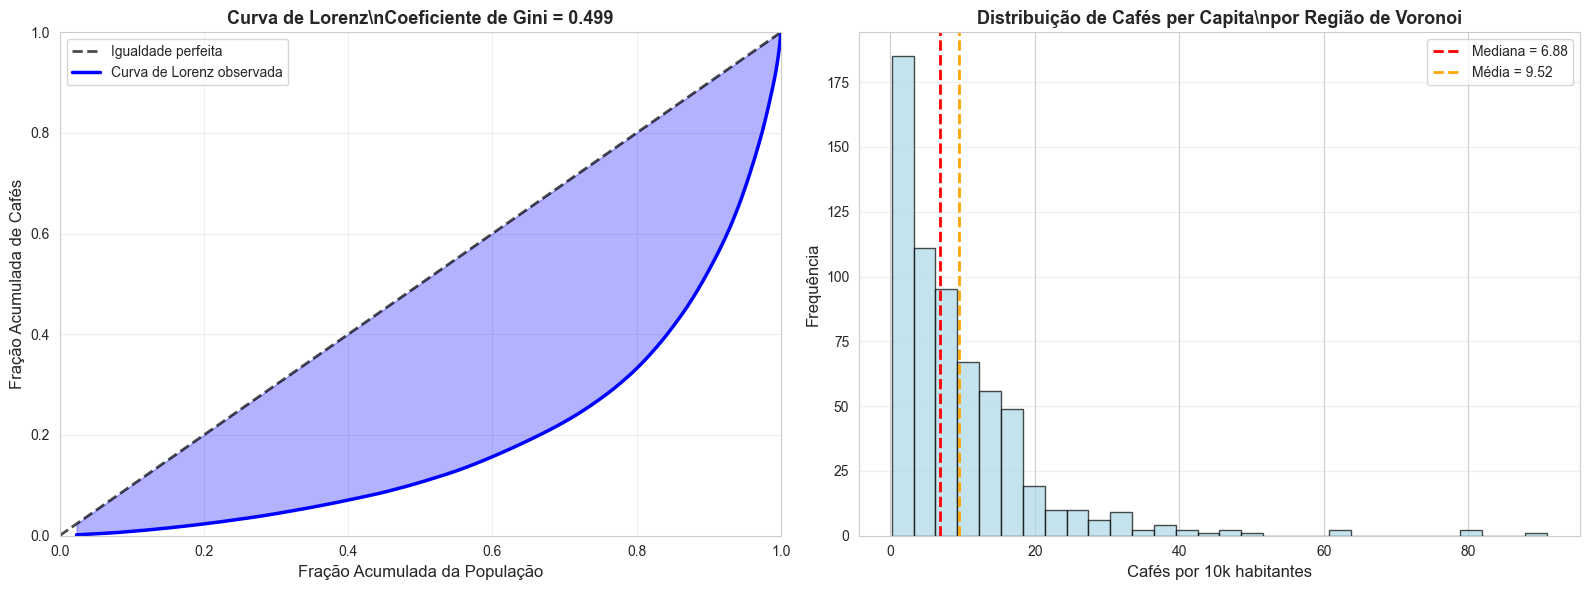

✓ Gráfico salvo em outputs/inequality_analysis.png


In [25]:
# Criar visualização combinada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Curva de Lorenz
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Igualdade perfeita', alpha=0.7)
ax1.plot(dados_desigualdade['pop_acumulada'], 
         dados_desigualdade['cafes_acumulados'],
         'b-', linewidth=2.5, label='Curva de Lorenz observada')
ax1.fill_between(dados_desigualdade['pop_acumulada'],
                  dados_desigualdade['cafes_acumulados'],
                  dados_desigualdade['pop_acumulada'],
                  alpha=0.3, color='blue')
ax1.set_xlabel('Fração Acumulada da População', fontsize=12)
ax1.set_ylabel('Fração Acumulada de Cafés', fontsize=12)
ax1.set_title(f'Curva de Lorenz\\nCoeficiente de Gini = {gini:.3f}', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Subplot 2: Histograma de cafés per capita
cafes_pc_nonzero = dados_desigualdade[dados_desigualdade['cafes_per_capita'] > 0]['cafes_per_capita']
ax2.hist(cafes_pc_nonzero, bins=30, color='lightblue', alpha=0.7, edgecolor='black')
ax2.axvline(cafes_pc_nonzero.median(), color='red', linestyle='--', 
            linewidth=2, label=f'Mediana = {cafes_pc_nonzero.median():.2f}')
ax2.axvline(cafes_pc_nonzero.mean(), color='orange', linestyle='--', 
            linewidth=2, label=f'Média = {cafes_pc_nonzero.mean():.2f}')
ax2.set_xlabel('Cafés por 10k habitantes', fontsize=12)
ax2.set_ylabel('Frequência', fontsize=12)
ax2.set_title('Distribuição de Cafés per Capita\\npor Região de Voronoi', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/inequality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo em outputs/inequality_analysis.png")

### Conclusões da Análise de Desigualdade

**Curva de Lorenz:**
- Quanto mais distante da linha de igualdade, maior a desigualdade
- A área entre a curva e a linha de igualdade representa a desigualdade

**Coeficiente de Gini:**
- Varia de 0 (igualdade perfeita) a 1 (desigualdade máxima)
- Valores típicos para serviços urbanos: 0.3 a 0.6

**Implicações:**
- Alta desigualdade pode indicar áreas subatendidas
- Baixa desigualdade sugere distribuição mais equitativa
- Deve ser analisado em conjunto com a densidade populacional e renda, uma cena pros proximos capitulos. 